### Multi-resolution image registration by homography transformation using matrix manifold optimization

In [1]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from skimage.transform import pyramid_gaussian
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm


from google.colab import drive
drive.mount('/content/drive')
#!ls "/content/drive/My Drive"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
cuda:0


(3072, 3900)


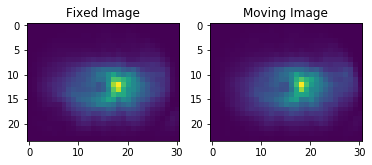

In [2]:
torch.manual_seed(0)
np.random.seed(0)
I = io.imread("/content/drive/My Drive/Colab Notebooks/fixed.bmp").astype(np.float32) # fixed image
J = io.imread("/content/drive/My Drive/Colab Notebooks/moving.bmp").astype(np.float32) # fixed image

pyramid_I = tuple(pyramid_gaussian(I, downscale=2, multichannel=False))
pyramid_J = tuple(pyramid_gaussian(J, downscale=2, multichannel=False))
########################################

%matplotlib inline
fig=plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(pyramid_I[7])
plt.title("Fixed Image")
fig.add_subplot(1,2,2)
plt.imshow(pyramid_J[7])         
plt.title("Moving Image")
# I = torch.tensor(pyramid_I[3].astype(np.float32)).to(device)
# tval = 0.9*threshold_otsu(I.cpu().numpy())
# height,width = I.shape
# important_ind = torch.nonzero((I.data>tval).view([height*width])).squeeze()
# I.view([height*width])[important_ind]
pyramid_I[0].shape[0]
print(pyramid_I[0].shape )

#part(a) Implemention of MINE algorithm

In [0]:
###############################################################################
n_epoch = 20 ##number of epochs
def batch(X,Y,joint=1):
    batch_size = X.shape[0] ##defining the batch size based on the input
    if joint == 1: ## defining the batch for joint distribution 
        batch1 = X
        batch2 = Y
    else:## defining the batch for marginal distribution 
        idx = torch.randperm(Y.nelement())
        Y = Y.view(-1)[idx].view(Y.size())### shuffling the Y in marginal distribution
        batch1 = X
        batch2 = Y
    return batch1.reshape(-1,1),batch2.reshape(-1,1)
  
class Network(nn.Module): ##a simple neural ntwork to predict the result based one the marginal and joint distribution 
    def __init__(self,input_size = 1, hidden_nodes = 20, output_size =1 ): 
        super(Network, self).__init__()
        self.f1 = nn.Linear(input_size,hidden_nodes).to(device)
        self.f2 = nn.Linear(input_size,hidden_nodes).to(device)
        self.f3 = nn.Linear(hidden_nodes,output_size).to(device)

    def forward(self, x, y):
        H1 = F.relu(self.f1(x)+self.f2(y)).to(device)
        H2 = self.f3(H1).to(device)
        return H2    


model_1 = Network()
def MINE(x_in, y_in):
    for epoch in (range(n_epoch)):
        x_in = x_in.to(device)
        y_in = y_in.to(device)
        x_sample_joint_1,y_sample_joint = batch(x_in,y_in, joint=1 )##getting batch for joint probabilities
        x_sample_joint_2,y_sample_marginal = batch(x_in,y_in, joint=0 )##getting batch for marginal probabilities
        
        ###############################################
        
        pred_xy = model_1(x_sample_joint_1,y_sample_joint)##sending the batch of joint probabilities to the network
        pred_x_y = model_1(x_sample_joint_2,y_sample_marginal)##sending the batch of matginal probabilities to the network
        
        ################################################
        v_theta = - ( torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y))) ) ##calculating v_theta based on our predictions that we get from the network
    return v_theta



In [0]:
#for part a uncomment this cell
# def MatrixExp(B, u):
#     C = torch.sum(B*u, 0)
#     A = torch.eye(3).to(device)
#     H = A
#     for i in torch.arange(1,10):
#         A =torch.mm(A/i,C)
#         H = H + A
#     return H

In [0]:
def PerspectiveTransform(I, H, xv, yv):
  
  # apply homography
  xvt = (xv*H[0,0]+yv*H[0,1]+H[0,2])/(xv*H[2,0]+yv*H[2,1]+H[2,2])
  yvt = (xv*H[1,0]+yv*H[1,1]+H[1,2])/(xv*H[2,0]+yv*H[2,1]+H[2,2])
  J = F.grid_sample(I.view(1,1,height,width),torch.stack([xvt,yvt],2).unsqueeze(0)).squeeze()
  return J


In [13]:
# perspective transform basis matrices

B = torch.zeros(8,3,3).to(device)
B[0,0,2] = 1.0
B[1,1,2] = 1.0
B[2,0,1] = 1.0
B[3,1,0] = 1.0
B[4,0,0], B[4,1,1] = 1.0, -1.0
B[5,1,1], B[5,2,2] = -1.0, 1.0
B[6,2,0] = 1.0
B[7,2,1] = 1.0

# multi-resolution registration
# Consider 8 levels in the pyramid for this example
learning_rate = 1e-3
nItr = torch.tensor([300,300,300,300,400,500,600,600])
# nItr = torch.tensor([30,30,30,30,30,30,30,30])
torch.autograd.set_detect_anomaly(True)

# create variables and optimization at each level
v = Variable(torch.zeros(8,1,1).to(device), requires_grad=True)

###############setting the optimizer

params = list(model_1.parameters()) + [v] 

optimizer = optim.Adam(params, lr=learning_rate, amsgrad=True)

##############
for level in torch.arange(7,-1,-1): # start at level 7
  if level>0:
    I = torch.tensor(pyramid_I[level].astype(np.float32)).to(device)
    J = torch.tensor(pyramid_J[level].astype(np.float32)).to(device)
  else:    
    I = torch.tensor(gaussian(pyramid_I[level].astype(np.float32),2.0)).to(device)
    J = torch.tensor(gaussian(pyramid_J[level].astype(np.float32),2.0)).to(device)
  
  height,width = I.shape

  # choose a set of pixel locations on the template image that are most informative
  tval = 0.9*threshold_otsu(I.cpu().numpy()) # reduce Otsu threshold value a bit to cover slightly wider areas
  important_ind = torch.nonzero((I.data>tval).view([height*width])).squeeze()

  # generate grid only once at each level
  yv, xv = torch.meshgrid([torch.arange(0,height).float().to(device), torch.arange(0,width).float().to(device)])
  # map coordinates to [-1,1]x[-1,1] so that grid_sample works properly
  yv = 2.0*yv/(height-1) - 1.0
  xv = 2.0*xv/(width-1) - 1.0
  for itr in range(nItr[level]):
    # input1 = B,v
    J_w = PerspectiveTransform(J,MatrixExp(B,v), xv, yv)
    loss = MINE(J_w.view([height*width])[important_ind], I.view([height*width])[important_ind])###replacing the mse loss function with the new MINE function 
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    if itr%100==0:
      print("Pyramid level:",level.item(),"Iteration:",itr,"MINE loss:",loss.item())
    optimizer.step()
  H = MatrixExp(B,v).detach()
  J_w = PerspectiveTransform(J, H, xv, yv)
  print("Pyramid level:",level.item(),"Iteration:",itr+1,"MINE loss:",loss.item())

# final transformation
I = torch.tensor(pyramid_I[0].astype(np.float32)).to(device) # without Gaussian
J = torch.tensor(pyramid_J[0].astype(np.float32)).to(device) # without Gaussian
J_w = PerspectiveTransform(J, H, xv, yv)

D = J - I
D_w = J_w - I
print(" ")
print("MINE before registration:",torch.mean(D**2).cpu().item())
print("MINE after registration:",torch.mean(D_w**2).cpu().item())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


Pyramid level: 7 Iteration: 0 MINE loss: 4.350550651550293
Pyramid level: 7 Iteration: 100 MINE loss: 0.05315697193145752
Pyramid level: 7 Iteration: 200 MINE loss: -0.524702787399292
Pyramid level: 7 Iteration: 300 MINE loss: -0.7321869134902954
Pyramid level: 7 Iteration: 400 MINE loss: -1.0090243816375732
Pyramid level: 7 Iteration: 500 MINE loss: -1.3181006908416748
Pyramid level: 7 Iteration: 600 MINE loss: -1.3160135746002197
Pyramid level: 6 Iteration: 0 MINE loss: -1.3788938522338867
Pyramid level: 6 Iteration: 100 MINE loss: -1.4683542251586914
Pyramid level: 6 Iteration: 200 MINE loss: -1.5267549753189087
Pyramid level: 6 Iteration: 300 MINE loss: -1.4080581665039062
Pyramid level: 6 Iteration: 400 MINE loss: -1.6918673515319824
Pyramid level: 6 Iteration: 500 MINE loss: -1.5503168106079102
Pyramid level: 6 Iteration: 600 MINE loss: -1.7567152976989746
Pyramid level: 5 Iteration: 0 MINE loss: -1.397249460220337
Pyramid level: 5 Iteration: 100 MINE loss: -1.516994833946228
Pyr

MI before registration: 0.7072216932289866
MI after registration: 0.9912910040124927
tensor([[ 1.0003,  0.0052,  0.0143],
        [-0.0050,  1.0000, -0.0017],
        [-0.0049,  0.0041,  0.9996]], device='cuda:0')


Text(0.5, 1.0, 'Difference image after registration')

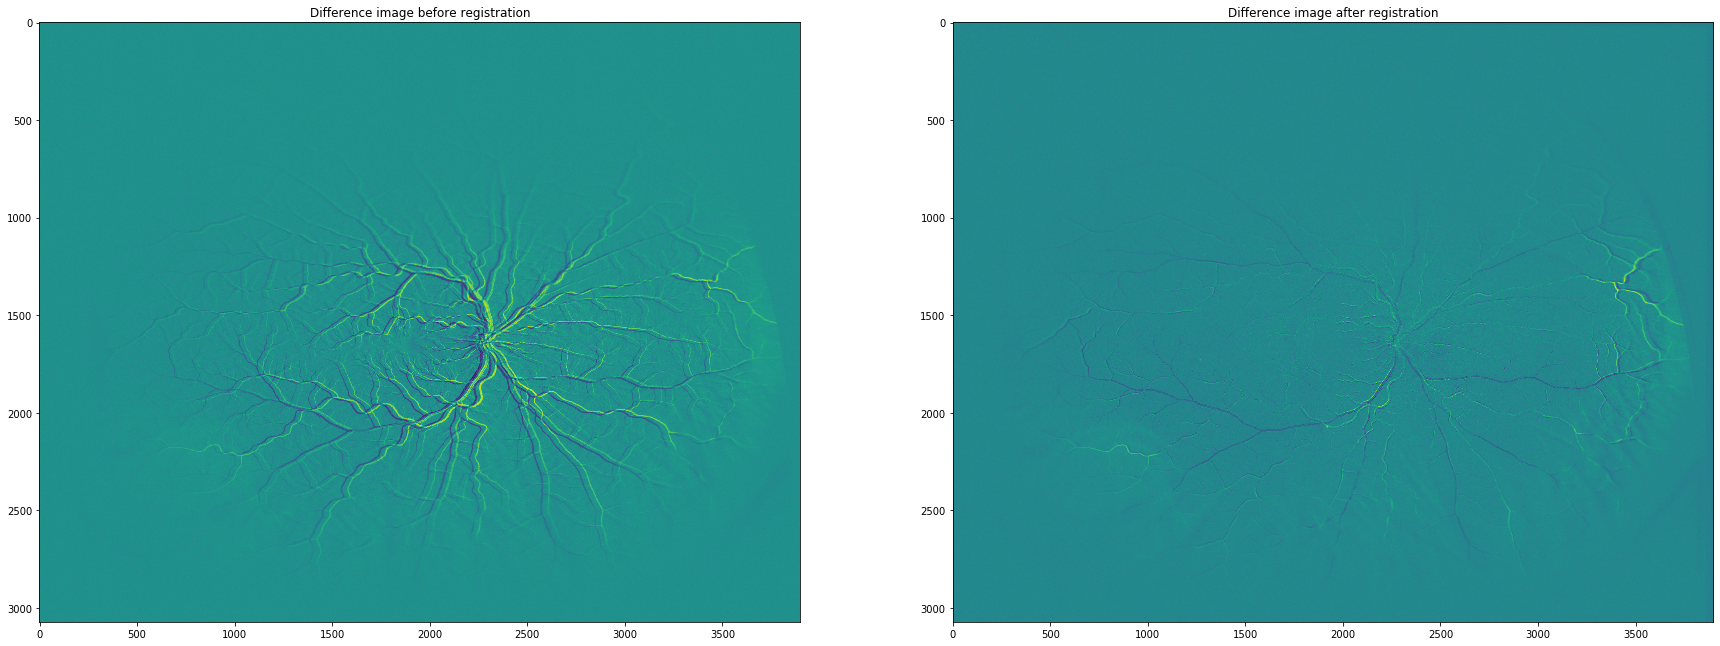

In [14]:
def histogram_mutual_information(image1, image2):
    hgram, x_edges, y_edges = np.histogram2d(image1.ravel(), image2.ravel(), bins=100)
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1)
    py = np.sum(pxy, axis=0)
    px_py = px[:, None] * py[None, :]
    nzs = pxy > 0
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

print("MI before registration:", histogram_mutual_information(pyramid_I[0],pyramid_J[0]))
print("MI after registration:", histogram_mutual_information(pyramid_I[0],J_w.cpu().numpy()))

print(H)
%matplotlib inline
fig=plt.figure(figsize=(30,30))
fig.add_subplot(1,2,1)
plt.imshow(D.cpu().data)
plt.title("Difference image before registration")
fig.add_subplot(1,2,2)
plt.imshow(D_w.cpu().data)         
plt.title("Difference image after registration")

# part(b) implementation of new backpropogation 

In [0]:
class MatrixExp(Function):

    # Note that both forward and backward are @staticmethods
    @staticmethod
    def forward(ctx, input1,input2):
        B = input1
        u = input2
        C = torch.sum(B*u, 0)
        A = torch.eye(3).to(device)
        H = A
        for i in torch.arange(1,10):
            A =torch.mm(A/i,C)
            H = H + A
        output = H
        ctx.save_for_backward(input1,input2,output)# these are the only tensors you will need to save for backward function
        return output.clone()

    @staticmethod
    def backward(ctx, grad_output):
        input1, input2, output = ctx.saved_tensors
        B = input1
        u = input2
        H = output
        Partial_derivative = torch.matmul(B,H) ##matrix multiplication 
        grad_weight = torch.zeros([8,1,1]).cuda()
        # for i in range (0,8,1): ### assigning the values in a loop 
        #     grad_weight[i][0][0] = torch.sum( torch.sum (torch.mul(Partial_derivative[i][:][:],grad_output), dim=1),dim=0)
        grad_weight = torch.sum( torch.sum (torch.mul(Partial_derivative,grad_output), dim=2),dim=1).t().unsqueeze(1).unsqueeze(2) ###vectorizing the loop
        return None, grad_weight

MatrixExp = MatrixExp.apply


In [16]:
# perspective transform basis matrices

B = torch.zeros(8,3,3).to(device)
B[0,0,2] = 1.0
B[1,1,2] = 1.0
B[2,0,1] = 1.0
B[3,1,0] = 1.0
B[4,0,0], B[4,1,1] = 1.0, -1.0
B[5,1,1], B[5,2,2] = -1.0, 1.0
B[6,2,0] = 1.0
B[7,2,1] = 1.0

# multi-resolution registration
# Consider 8 levels in the pyramid for this example
learning_rate = 1e-3
nItr = torch.tensor([300,300,300,300,400,500,600,600])
# nItr = torch.tensor([30,30,30,30,30,30,30,30])
torch.autograd.set_detect_anomaly(True)

# create variables and optimization at each level
v = Variable(torch.zeros(8,1,1).to(device), requires_grad=True)

###############setting the optimizer

params = list(model_1.parameters()) + [v] 

optimizer = optim.Adam(params, lr=learning_rate, amsgrad=True)

##############
for level in torch.arange(7,-1,-1): # start at level 7
  if level>0:
    I = torch.tensor(pyramid_I[level].astype(np.float32)).to(device)
    J = torch.tensor(pyramid_J[level].astype(np.float32)).to(device)
  else:    
    I = torch.tensor(gaussian(pyramid_I[level].astype(np.float32),2.0)).to(device)
    J = torch.tensor(gaussian(pyramid_J[level].astype(np.float32),2.0)).to(device)
  
  height,width = I.shape

  # choose a set of pixel locations on the template image that are most informative
  tval = 0.9*threshold_otsu(I.cpu().numpy()) # reduce Otsu threshold value a bit to cover slightly wider areas
  important_ind = torch.nonzero((I.data>tval).view([height*width])).squeeze()

  # generate grid only once at each level
  yv, xv = torch.meshgrid([torch.arange(0,height).float().to(device), torch.arange(0,width).float().to(device)])
  # map coordinates to [-1,1]x[-1,1] so that grid_sample works properly
  yv = 2.0*yv/(height-1) - 1.0
  xv = 2.0*xv/(width-1) - 1.0
  for itr in range(nItr[level]):
    # input1 = B,v
    J_w = PerspectiveTransform(J,MatrixExp(B,v), xv, yv)
    loss = MINE(J_w.view([height*width])[important_ind], I.view([height*width])[important_ind])
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    if itr%100==0:
      print("Pyramid level:",level.item(),"Iteration:",itr,"MINE loss:",loss.item())
    optimizer.step()
  H = MatrixExp(B,v).detach()
  J_w = PerspectiveTransform(J, H, xv, yv)
  print("Pyramid level:",level.item(),"Iteration:",itr+1,"MINE loss:",loss.item())

# final transformation
I = torch.tensor(pyramid_I[0].astype(np.float32)).to(device) # without Gaussian
J = torch.tensor(pyramid_J[0].astype(np.float32)).to(device) # without Gaussian
J_w = PerspectiveTransform(J, H, xv, yv)

D = J - I
D_w = J_w - I
print(" ")
print("MSE before registration:",torch.mean(D**2).cpu().item())
print("MSE after registration:",torch.mean(D_w**2).cpu().item())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


Pyramid level: 7 Iteration: 0 MINE loss: -1.2657828330993652
Pyramid level: 7 Iteration: 100 MINE loss: -2.053415298461914
Pyramid level: 7 Iteration: 200 MINE loss: -1.9327387809753418
Pyramid level: 7 Iteration: 300 MINE loss: -1.520196557044983
Pyramid level: 7 Iteration: 400 MINE loss: -2.2783756256103516
Pyramid level: 7 Iteration: 500 MINE loss: -2.2195351123809814
Pyramid level: 7 Iteration: 600 MINE loss: -2.096078872680664
Pyramid level: 6 Iteration: 0 MINE loss: -1.8684206008911133
Pyramid level: 6 Iteration: 100 MINE loss: -1.8151439428329468
Pyramid level: 6 Iteration: 200 MINE loss: -1.9331501722335815
Pyramid level: 6 Iteration: 300 MINE loss: -1.796665072441101
Pyramid level: 6 Iteration: 400 MINE loss: -1.6926103830337524
Pyramid level: 6 Iteration: 500 MINE loss: -1.6320760250091553
Pyramid level: 6 Iteration: 600 MINE loss: -1.8162471055984497
Pyramid level: 5 Iteration: 0 MINE loss: -1.4209084510803223
Pyramid level: 5 Iteration: 100 MINE loss: -1.7690017223358154
Py

MI before registration: 0.7072216932289866
MI after registration: 0.991341118883799
tensor([[ 1.0004,  0.0052,  0.0143],
        [-0.0051,  0.9999, -0.0017],
        [-0.0048,  0.0042,  0.9996]], device='cuda:0')


Text(0.5, 1.0, 'Difference image after registration')

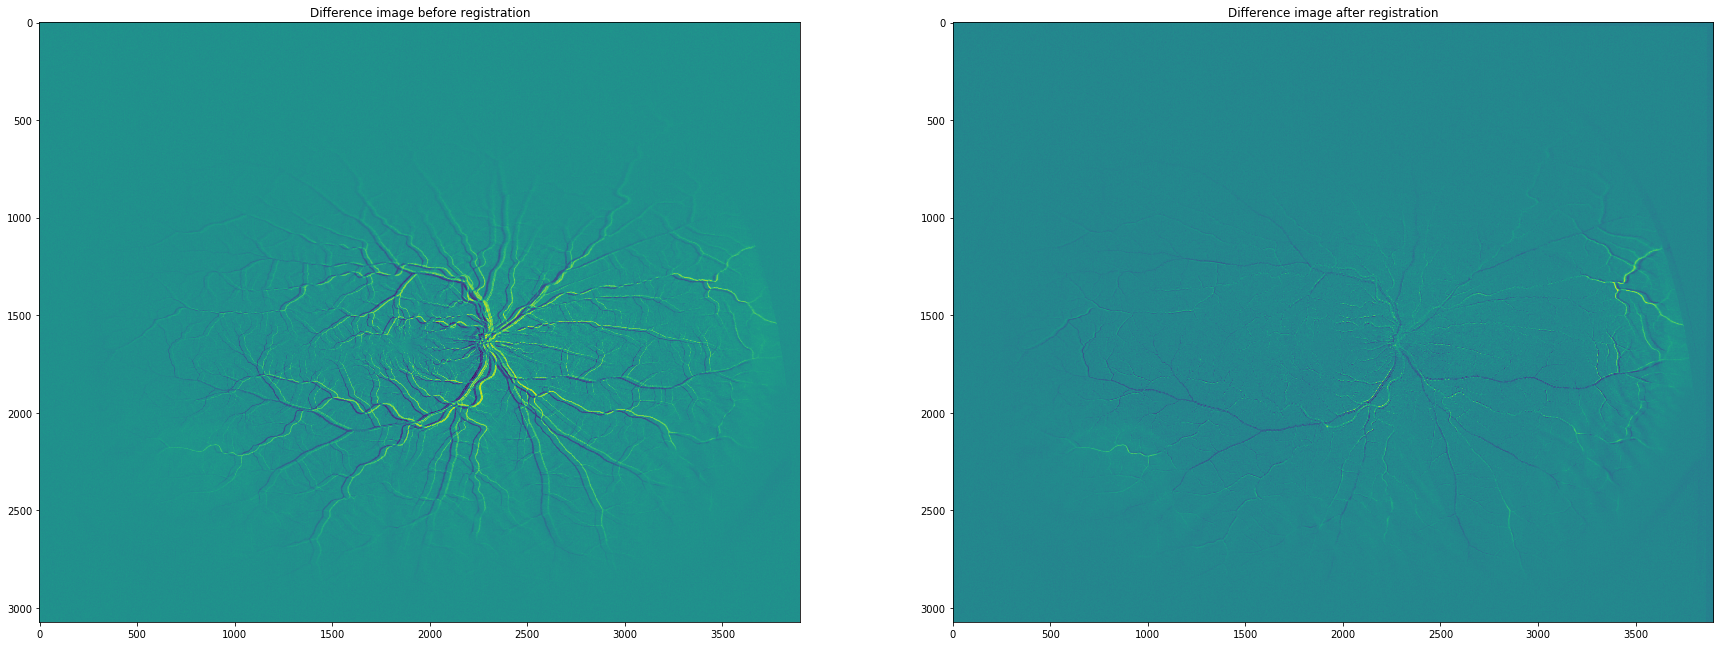

In [17]:
def histogram_mutual_information(image1, image2):
    hgram, x_edges, y_edges = np.histogram2d(image1.ravel(), image2.ravel(), bins=100)
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1)
    py = np.sum(pxy, axis=0)
    px_py = px[:, None] * py[None, :]
    nzs = pxy > 0
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

print("MI before registration:", histogram_mutual_information(pyramid_I[0],pyramid_J[0]))
print("MI after registration:", histogram_mutual_information(pyramid_I[0],J_w.cpu().numpy()))

print(H)
%matplotlib inline
fig=plt.figure(figsize=(30,30))
fig.add_subplot(1,2,1)
plt.imshow(D.cpu().data)
plt.title("Difference image before registration")
fig.add_subplot(1,2,2)
plt.imshow(D_w.cpu().data)         
plt.title("Difference image after registration")